# Atelier Topic Modelling - Site TripAdvisor - Groupe 8

## 1.WebScraping

In [ ]:
import requests             
from bs4 import BeautifulSoup 
import csv                  
import webbrowser
import io
import os



def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
        f.write(content)
        webbrowser.open(filename)

def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')
    
def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)
    
    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')
    
def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })
    i=0
    for i in range (0,2):
        items = parse(session, url + '?filterLang=' + lang)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    #num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    #num_reviews = num_reviews[1:-1] 
    #num_reviews = num_reviews.replace(',', '')
    #num_reviews = int(num_reviews) # convert text into integer
    #print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    #while(True):
    subpage_url = url_template.format(offset)

    subpage_items = parse_reviews(session, subpage_url)
    #if not subpage_items:
        #break

    #items += subpage_items

    #if len(subpage_items) < 5:
        #break

    #offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids
    
def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', id='HEADING').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    #soup = get_more(session, reviews_ids)

    #if not soup:
        #print('[parse_reviews] no soup:', url)
        #return

    items = []
    

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
            
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        

       # Reviewer = soup.find('span',{"class": "expand_inline scrname"})



        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
           # 'hotel_name': response.find('h1', class_='heading_title').text,
            'review_title': review.find('span', class_='noQuotes').text,
           # 'review_body1': review.find('p', class_='partial_entry').text,
            #'review_date1': review.find('span', class_='relativeDate')['title'],#.text,#[idx],
            'num_reviews_reviewer': review.find('span', class_='badgetext').text,
            #'reviewer_name': Reviewer,
            'bubble_rating': bubble_rating[0],
        }

        items.append(item)
        Record1=""
        #print('\n--- review ---\n')
        for key,val in item.items():
            #print(' ', key, ':', val)
            Record1=Record1+";"+val
            Record=Record1[1:]
        file.write(bytes(Record, encoding="ascii", errors='ignore')  + b"\n")

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
                  mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)
        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='num_reviews_reviewer'
DB_COLUMN4   ='bubble_rating'

start_urls = [
    'https://www.tripadvisor.fr/ShowUserReviews-g1067681-d8297755-r604028753-McDonald_s-Revel_Haute_Garonne_Occitanie.html',
]

lang = 'en'

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1, 
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
]

for url in start_urls:
    file = open(os.path.expanduser(r"C:/Users/lenovo/Desktop/ESPRIT4DS/2eme_semestre/TripAdvisorReviw.csv"), "wb")
    file.write(
    b"review_body;review_date;review_title;num_reviews_reviewer;bubble_rating" + b"\n")

    # get all reviews for 'url' and 'lang'
    items = scrape(url, lang)
    file.close()
    
    print("aaaaa")
    
    for key,val in items():
            print(' ', key, ':', val)

    if not items:
        print('No reviews')
    #else:
        # write in CSV
        #filename = url.split('Reviews-')[1][:-5] + '__' + lang
        #filename='results'
        #print('filename:', filename)
        #write_in_csv(items, filename + '.csv', headers, mode='w')

# 2- Prétraiter des données

In [1]:
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint
import tweepy
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.models import CoherenceModel
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

unable to import 'smart_open.gcs', disabling that module


In [2]:
import pandas as pd
df = pd.read_csv("TripAdvisorReview.csv")

In [3]:
import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
from gensim import corpora, models, similarities
import time
import operator

In [4]:
import spacy
nlp = spacy.load("fr_core_news_sm")

In [5]:
content = df.review_body

In [6]:
content

0     Arriv  22h00 un lundi soir au drive une voitur...
1     Plus de 30 minutes pour attendre ca commande 1...
2     Personnel accueillant mais table extrieure tou...
3     Petit arrt pour le repas du midi ,trs bon accu...
4     Ce Mac Donald est parfait pour y manger avec d...
5     Contrairement aux diffrents commentaires que j...
6     Nous avons effectu une commande internet afin ...
7     C'est le seul Mcdo ou aprs une trs longue atte...
8     Je n'y allais dj pas souvent, mais depuis ma d...
9     franchement rien de spcial ce soir on prend  e...
10    Le lieu etait quasi vide et plutot sale: des m...
11    personnel dsagrable et on ne peut faire aucune...
12    Le.mac do devient de plus en plus cher, quelle...
13    Le Mc Donald's de Revel est 1 dlice et je pens...
14    Nous avons attendu plus de vingt minutes en vo...
15    Ce restaurant n'est pas propre, je le signale ...
16    Bonjour  tous, Que dire de ce restaurant????? ...
17    Ni bonjour ni demander ce que l'on voulait

In [7]:
preparing_data = []

## Tokenize:

In [8]:
# Tokenisation par phrases
def return_token_sent(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque phrase
    return [X.text for X in doc.sents]

In [9]:
phrases = []
for ph in content:
    phrases.append(return_token_sent(ph))

In [10]:
phrases[0]

['Arriv  22h00',
 "un lundi soir au drive une voiture devant nous plus de 30min d'attente",
 "aucun geste commercial bref que dire les produits taient limites tu paye presque 15 euros un menu signature et il n'y a presque rien",
 'dedans.',
 "Le problme ne vien pas du personnel mais de la direction c'tait pas comme a avant."]

In [11]:
# Tokenisation par mots
def return_token(sentence):
    # Tokeniser la phrase
    doc = nlp(sentence)
    # Retourner le texte de chaque token
    return [X.text for X in doc]

In [12]:
for ph in content:
    preparing_data.append(return_token(ph))

In [13]:
print(preparing_data[0])

['Arriv', ' ', '22h00', 'un', 'lundi', 'soir', 'au', 'drive', 'une', 'voiture', 'devant', 'nous', 'plus', 'de', '30min', "d'", 'attente', 'aucun', 'geste', 'commercial', 'bref', 'que', 'dire', 'les', 'produits', 'taient', 'limites', 'tu', 'paye', 'presque', '15', 'euros', 'un', 'menu', 'signature', 'et', 'il', "n'", 'y', 'a', 'presque', 'rien', 'dedans', '.', 'Le', 'problme', 'ne', 'vien', 'pas', 'du', 'personnel', 'mais', 'de', 'la', 'direction', "c'", 'tait', 'pas', 'comme', 'a', 'avant', '.']


In [14]:
preparing_data

[['Arriv',
  ' ',
  '22h00',
  'un',
  'lundi',
  'soir',
  'au',
  'drive',
  'une',
  'voiture',
  'devant',
  'nous',
  'plus',
  'de',
  '30min',
  "d'",
  'attente',
  'aucun',
  'geste',
  'commercial',
  'bref',
  'que',
  'dire',
  'les',
  'produits',
  'taient',
  'limites',
  'tu',
  'paye',
  'presque',
  '15',
  'euros',
  'un',
  'menu',
  'signature',
  'et',
  'il',
  "n'",
  'y',
  'a',
  'presque',
  'rien',
  'dedans',
  '.',
  'Le',
  'problme',
  'ne',
  'vien',
  'pas',
  'du',
  'personnel',
  'mais',
  'de',
  'la',
  'direction',
  "c'",
  'tait',
  'pas',
  'comme',
  'a',
  'avant',
  '.'],
 ['Plus',
  'de',
  '30',
  'minutes',
  'pour',
  'attendre',
  'ca',
  'commande',
  '1',
  'happy',
  'meal',
  '1',
  'salade',
  'et',
  '1',
  'glace',
  'honteux',
  'et',
  'il',
  'et',
  '14h20',
  'a',
  'l',
  'heure',
  'de',
  'la',
  'commande',
  'il',
  'a',
  'fallu',
  'aller',
  'chercher',
  'son',
  'plateau',
  'pour',
  'manger',
  'merci',
  'le',


## 2.3. Enlever les mots les plus fréquents (stop wards)

In [15]:
# Certains mots se retrouvent très fréquemment dans la langue française.
# on souhaite limiter la quantité de mots dans les données d’entraînement.
filtering_data = []

In [16]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('french'))
# print(stopWords)

In [17]:
for stop_words in preparing_data:
    filtered_sentence = [w for w in stop_words if not w in stopWords]
    filtering_data.append(filtered_sentence)

In [18]:
print(filtering_data[0])

['Arriv', ' ', '22h00', 'lundi', 'soir', 'drive', 'voiture', 'devant', 'plus', '30min', "d'", 'attente', 'aucun', 'geste', 'commercial', 'bref', 'dire', 'produits', 'taient', 'limites', 'paye', 'presque', '15', 'euros', 'menu', 'signature', "n'", 'a', 'presque', 'rien', 'dedans', '.', 'Le', 'problme', 'vien', 'personnel', 'direction', "c'", 'tait', 'comme', 'a', 'avant', '.']


## 2.2. transformer les mots en minuscules et enlever la ponctuation

In [19]:
# definir les ponctuations, en ajoutant le vide et l'espce à la liste.
import string
punctuations = list(string.punctuation)
punctuations.append("''")
punctuations.append(" ")

In [20]:
no_ponctuations = []
for stop_words in filtering_data:
    filtered_sentence = [w.lower() for w in stop_words if not w in punctuations]
    no_ponctuations.append(filtered_sentence)

In [21]:
print(no_ponctuations[0])

['arriv', '22h00', 'lundi', 'soir', 'drive', 'voiture', 'devant', 'plus', '30min', "d'", 'attente', 'aucun', 'geste', 'commercial', 'bref', 'dire', 'produits', 'taient', 'limites', 'paye', 'presque', '15', 'euros', 'menu', 'signature', "n'", 'a', 'presque', 'rien', 'dedans', 'le', 'problme', 'vien', 'personnel', 'direction', "c'", 'tait', 'comme', 'a', 'avant']


## 2.4. Appliquer la lemmatisation et le stemming

In [22]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

def return_stem(sentence):
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [23]:
stemmed = []
for stop_words in no_ponctuations:
    filtered_sentence = [w.lower() for w in stop_words]
    stemmed.append(filtered_sentence)

In [24]:
print(stemmed[0])

['arriv', '22h00', 'lundi', 'soir', 'drive', 'voiture', 'devant', 'plus', '30min', "d'", 'attente', 'aucun', 'geste', 'commercial', 'bref', 'dire', 'produits', 'taient', 'limites', 'paye', 'presque', '15', 'euros', 'menu', 'signature', "n'", 'a', 'presque', 'rien', 'dedans', 'le', 'problme', 'vien', 'personnel', 'direction', "c'", 'tait', 'comme', 'a', 'avant']


In [25]:
# limitizing by default return a noun
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatized=[]
lemmatizer = WordNetLemmatizer()
lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in stemmed]
#print(lemmatizer.lemmatize("better",pos='a')) # pos='a'  adj

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
lemmatized

[['arriv',
  '22h00',
  'lundi',
  'soir',
  'drive',
  'voiture',
  'devant',
  'plus',
  '30min',
  "d'",
  'attente',
  'aucun',
  'geste',
  'commercial',
  'bref',
  'dire',
  'produits',
  'taient',
  'limites',
  'paye',
  'presque',
  '15',
  'euro',
  'menu',
  'signature',
  "n'",
  'a',
  'presque',
  'rien',
  'dedans',
  'le',
  'problme',
  'vien',
  'personnel',
  'direction',
  "c'",
  'tait',
  'comme',
  'a',
  'avant'],
 ['plus',
  '30',
  'minute',
  'attendre',
  'ca',
  'commande',
  '1',
  'happy',
  'meal',
  '1',
  'salade',
  '1',
  'glace',
  'honteux',
  '14h20',
  'a',
  'heure',
  'commande',
  'a',
  'fallu',
  'aller',
  'chercher',
  'plateau',
  'manger',
  'merci',
  'service',
  'a',
  'table'],
 ['personnel',
  'accueillant',
  'table',
  'extrieure',
  'toujours',
  'sale',
  'nettoyer',
  'rgulirement',
  'attire',
  'gupes',
  'esprant',
  'qun',
  'enfants',
  'fasse',
  'pique'],
 ['petit',
  'arrt',
  'repas',
  'midi',
  'trs',
  'bon',
  'ac

## 5. Id Term dictionary

In [27]:
reviews_dict = corpora.Dictionary(lemmatized)
print (reviews_dict)
#print(reviews_dict.token2id.items())

Dictionary(776 unique tokens: ['15', '22h00', '30min', 'a', 'arriv']...)


In [28]:
# filter tokens
#reviews_dict1=reviews_dict
#reviews_dict1.filter_extremes(no_below=30,  keep_n=100000) # changes reviews_dict in place
#print(reviews_dict1)

=> Içi vu que le nombre de review n'est pas trop grand on ne peut pas appliquer un filtre pour le dictionnaire.
Alors on va travailler avec reviews_dict

## 6. Bag of words

In [29]:
bow_corpus = [reviews_dict.doc2bow(review_doc) for review_doc in lemmatized]

In [30]:
bow_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(3, 3),
  (27, 1),
  (38, 3),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1)],
 [(26, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1)],
 [(10, 1),
  (27, 1),
  (41, 1),
  (43, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 

## 7. TF-IDF Model

In [31]:
# Create the TF-IDF model
model_tfidf = models.TfidfModel(bow_corpus, smartirs='ntc')

In [32]:
corpus_tfidf = model_tfidf[bow_corpus]
corpus_tfidf[0]

[(0, 0.14025003062705205),
 (1, 0.20296756372016644),
 (2, 0.20296756372016644),
 (3, 0.08937226584794569),
 (4, 0.16339720602111804),
 (5, 0.10067967292800364),
 (6, 0.16339720602111804),
 (7, 0.0918795252661629),
 (8, 0.16339720602111804),
 (9, 0.08425649062302125),
 (10, 0.0918795252661629),
 (11, 0.20296756372016644),
 (12, 0.07753249753393764),
 (13, 0.16339720602111804),
 (14, 0.20296756372016644),
 (15, 0.12382684832206964),
 (16, 0.12382684832206964),
 (17, 0.11108803845400353),
 (18, 0.20296756372016644),
 (19, 0.20296756372016644),
 (20, 0.05230916756711452),
 (21, 0.20296756372016644),
 (22, 0.20296756372016644),
 (23, 0.16339720602111804),
 (24, 0.08425649062302125),
 (25, 0.20296756372016644),
 (26, 0.0660766171352906),
 (27, 0.041225197010321825),
 (28, 0.4059351274403329),
 (29, 0.16339720602111804),
 (30, 0.12382684832206964),
 (31, 0.10067967292800364),
 (32, 0.20296756372016644),
 (33, 0.12382684832206964),
 (34, 0.12382684832206964),
 (35, 0.11108803845400353),
 (36,

## 8. LDA Model 

In [33]:
from gensim.models import LdaModel, LdaMulticore
# Create the model
model_lda = LdaMulticore(corpus=bow_corpus,
                         id2word=reviews_dict,
                         random_state=100,
                         num_topics=7,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

# save the model
model_lda.save('lda_model.model')

In [34]:

print(model_lda.top_topics(bow_corpus)[0:2])

[([(0.013422258, 'a'), (0.008056738, 'sol'), (0.006328914, 'plus'), (0.0062362864, 'fait'), (0.004607206, 'employ'), (0.0045933262, 'impossible'), (0.004588861, 'de'), (0.004584138, 'tout'), (0.004495779, 'glaces'), (0.004491377, "c'"), (0.004472245, "l'"), (0.0044268165, 'pouse'), (0.003205158, "n'"), (0.0029575687, 'passerait'), (0.0029330826, "d'"), (0.0029179351, 'laccueil'), (0.0029169268, 'attention'), (0.002897768, 'donner'), (0.002883886, 'rien'), (0.0028654549, 'lunette')], -1.1165765333800106), ([(0.0065818056, 'client'), (0.0065811444, "n'"), (0.006518126, 'restaurant'), (0.004868611, 'pose'), (0.0047819624, 'ni'), (0.004761114, 'je'), (0.0047395644, 'personnel'), (0.0046992246, 'pris'), (0.0030712776, 'ngligence'), (0.003039256, 'propre'), (0.0030228908, 'cigarette'), (0.0030151687, 'tard'), (0.00301316, "c'"), (0.0030069666, 'alors'), (0.003002174, '2'), (0.0029928752, 'sale'), (0.0029890982, 'passez'), (0.002980072, 'minute'), (0.0029743132, 'personne'), (0.0029733384, 'b

In [35]:
# See the topics
for idx,topic in model_lda.print_topics():
    print('Topic {} : Word: {}'.format(idx,topic))

Topic 0 : Word: 0.013*"plus" + 0.010*"commande" + 0.010*"le" + 0.008*"d'" + 0.007*"fois" + 0.006*"j'" + 0.006*"a" + 0.006*"temp" + 0.006*"mc" + 0.005*"tre"
Topic 1 : Word: 0.010*"a" + 0.008*"d'" + 0.008*"personnel" + 0.007*"trs" + 0.007*"c'" + 0.006*"commande" + 0.006*"s'" + 0.006*"client" + 0.005*"bien" + 0.005*"j'"
Topic 2 : Word: 0.013*"a" + 0.008*"sol" + 0.006*"plus" + 0.006*"fait" + 0.005*"employ" + 0.005*"impossible" + 0.005*"de" + 0.005*"tout" + 0.004*"glaces" + 0.004*"c'"
Topic 3 : Word: 0.017*"a" + 0.010*"l'" + 0.008*"plus" + 0.008*"soir" + 0.007*"personnel" + 0.006*"..." + 0.006*"1" + 0.005*"trs" + 0.005*"intrieur" + 0.005*"fois"
Topic 4 : Word: 0.007*"client" + 0.007*"n'" + 0.007*"restaurant" + 0.005*"pose" + 0.005*"ni" + 0.005*"je" + 0.005*"personnel" + 0.005*"pris" + 0.003*"ngligence" + 0.003*"propre"
Topic 5 : Word: 0.002*"maintenant" + 0.002*"semble" + 0.002*"lamentable" + 0.002*"accueil" + 0.002*"idem" + 0.002*"malgr" + 0.002*"14" + 0.002*"2" + 0.002*"pas" + 0.001*"poub

## 9. Modèle LDA-TFIDF

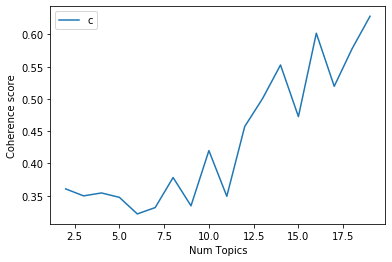

In [36]:
from gensim.models import CoherenceModel
# Hyperparameter Tuning

topics_range = range(2, 20, 1)
model_results = { 'Topics': [],
                 'Coherence': []
                }

for k in topics_range:
    lda_model_test = LdaMulticore(corpus=corpus_tfidf, id2word=reviews_dict, num_topics=k, random_state=42, chunksize=100, iterations=25, passes=2, workers=3)
    coherence_model_lda = CoherenceModel(model=lda_model_test, texts=lemmatized, dictionary=reviews_dict, coherence='c_v')    
    cv = coherence_model_lda.get_coherence()
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

plt.plot(model_results['Topics'], model_results['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

=> D'après ce graphe on peut dire que le nombre de topic optimal=4

In [37]:
# On va maintenant appliquer lDA en utilisant TF-IDF
model_tfidf_lda = LdaMulticore(corpus_tfidf,num_topics=4,random_state=42, id2word=reviews_dict, chunksize=100, iterations=25, passes=2, workers=3)

In [38]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_tfidf_lda, corpus_tfidf, reviews_dict)
vis

C:\Users\lenovo\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.014557  0.000149       1        1  38.730103
0      0.006188  0.007141       2        1  23.858624
3      0.005161 -0.009536       3        1  19.605812
1      0.003208  0.002246       4        1  17.805458, topic_info=    Category      Freq          Term     Total  loglift  logprob
93   Default  0.000000         petit  0.000000  30.0000  30.0000
430  Default  0.000000       vrifier  0.000000  29.0000  29.0000
220  Default  0.000000            s'  0.000000  28.0000  28.0000
347  Default  0.000000       donald'  0.000000  27.0000  27.0000
343  Default  0.000000         avoir  0.000000  26.0000  26.0000
88   Default  0.000000     formation  0.000000  25.0000  25.0000
225  Default  0.000000     commandes  0.000000  24.0000  24.0000
335  Default  0.000000        petits  0.000000  23.0000  23.0000
667  Default  0.000000         route  0.000000  22.0000  22.0000
666  Default  0.000000        rapide  0.000000  21.0000  21.0000
668  Default  0.000000        sortie  0.000000  20.0000  20.0000
665  Default  0.000000          plac  0.000000  19.0000  19.0000
664  Default  0.000000          bmol  0.000000  18.0000  18.0000
28   Default  0.000000       presque  0.000000  17.0000  17.0000
107  Default  0.000000     identique  0.000000  16.0000  16.0000
109  Default  0.000000        lcoute  0.000000  15.0000  15.0000
8    Default  0.000000          bref  0.000000  14.0000  14.0000
540  Default  0.000000      intrieur  0.000000  13.0000  13.0000
116  Default  0.000000         13h30  0.000000  12.0000  12.0000
114  Default  0.000000     serviable  0.000000  11.0000  11.0000
112  Default  0.000000       parfait  0.000000  10.0000  10.0000
138  Default  0.000000         poque  0.000000   9.0000   9.0000
105  Default  0.000000        donald  0.000000   8.0000   8.0000
113  Default  0.000000     plusieurs  0.000000   7.0000   7.0000
104  Default  0.000000        chaque  0.000000   6.0000   6.0000
342  Default  0.000000             0  0.000000   5.0000   5.0000
62   Default  0.000000       esprant  0.000000   4.0000   4.0000
68   Default  0.000000           qun  0.000000   3.0000   3.0000
67   Default  0.000000         pique  0.000000   2.0000   2.0000
65   Default  0.000000         gupes  0.000000   1.0000   1.0000
..       ...       ...           ...       ...      ...      ...
93    Topic4  0.100740         petit  0.304841   0.6184  -5.8324
225   Topic4  0.089257     commandes  0.270738   0.6160  -5.9534
684   Topic4  0.075152         moins  0.236679   0.5785  -6.1254
696   Topic4  0.076540        erreur  0.243124   0.5699  -6.1071
333   Topic4  0.071971           met  0.230936   0.5598  -6.1686
338   Topic4  0.071966        quelle  0.230934   0.5597  -6.1687
336   Topic4  0.071961     peufrites  0.230929   0.5597  -6.1688
339   Topic4  0.071958  rempliglaces  0.230930   0.5596  -6.1688
330   Topic4  0.071957       horreur  0.230931   0.5596  -6.1688
326   Topic4  0.071954            an  0.230929   0.5596  -6.1689
328   Topic4  0.071943       devient  0.230940   0.5594  -6.1690
340   Topic4  0.071939         steak  0.230936   0.5593  -6.1691
327   Topic4  0.071939          cher  0.230941   0.5593  -6.1691
331   Topic4  0.071930          idem  0.230949   0.5592  -6.1692
332   Topic4  0.071911        le.mac  0.230953   0.5589  -6.1695
88    Topic4  0.087987     formation  0.282691   0.5585  -5.9677
110   Topic4  0.074948          mang  0.249427   0.5233  -6.1281
263   Topic4  0.078274      emporter  0.266252   0.5014  -6.0847
347   Topic4  0.080733       donald'  0.279084   0.4853  -6.0538
209   Topic4  0.082846          temp  0.315083   0.3898  -6.0279
61    Topic4  0.081238       enfants  0.342372   0.2871  -6.0475
106   Topic4  0.081976          fois  0.363571   0.2361  -6.0385
113   Topic4  0.074246     plusieurs  0.259142   0.4757  -6.1375
104   Topic4  0.074122        chaque  0.259224   0.4737  -

In [39]:
print(model_tfidf_lda.top_topics(bow_corpus)[0:2])

[([(0.003621706, 'a'), (0.0033668668, '...'), (0.0032270164, "j'"), (0.0031974416, 'ni'), (0.0031546478, '1'), (0.002863142, 'commande'), (0.0027560056, 'restaurant'), (0.002717156, 'serviette'), (0.0027063566, 'personne'), (0.0026776483, 'dsagrable'), (0.0026218449, 'trs'), (0.002602322, 'dit'), (0.0025850197, 'do'), (0.0025269743, 'mac'), (0.0025076796, 'tout'), (0.0024731224, 'sale'), (0.002457886, 'souvent'), (0.0024386453, 'hamburger'), (0.00243043, 'minute'), (0.0024030244, 'pose')], -10.41697973277155), ([(0.0033710084, "s'"), (0.0032120878, "c'"), (0.002921516, "n'"), (0.0028018546, 'je'), (0.002738449, "d'"), (0.0025963483, 'mcdo'), (0.0025803274, 'midi'), (0.0025678433, 'accueil'), (0.0025114017, 'plutt'), (0.0024375427, "mcdonald'"), (0.002395649, 'eux'), (0.0023950893, 'clean'), (0.0023945405, 'quoi'), (0.0023929672, 'beurk'), (0.0023910492, 'pro'), (0.00238942, 'resto'), (0.0022458935, 'excuse'), (0.0022237666, "j'"), (0.0022072413, 'car'), (0.0022030014, 'arrivent')], -15

In [40]:
for idx,topic in model_tfidf_lda.print_topics():
    print('Topic {} : Word: {}'.format(idx,topic))

Topic 0 : Word: 0.003*"s'" + 0.003*"c'" + 0.003*"n'" + 0.003*"je" + 0.003*"d'" + 0.003*"mcdo" + 0.003*"midi" + 0.003*"accueil" + 0.003*"plutt" + 0.002*"mcdonald'"
Topic 1 : Word: 0.003*"petit" + 0.003*"vrifier" + 0.003*"commandes" + 0.003*"formation" + 0.003*"petits" + 0.002*"route" + 0.002*"rapide" + 0.002*"sortie" + 0.002*"plac" + 0.002*"bmol"
Topic 2 : Word: 0.004*"a" + 0.003*"..." + 0.003*"j'" + 0.003*"ni" + 0.003*"1" + 0.003*"commande" + 0.003*"restaurant" + 0.003*"serviette" + 0.003*"personne" + 0.003*"dsagrable"
Topic 3 : Word: 0.003*"l'" + 0.003*"avoir" + 0.003*"intrieur" + 0.003*"presque" + 0.003*"bref" + 0.002*"13h30" + 0.002*"poque" + 0.002*"toutes" + 0.002*"esprant" + 0.002*"pique"


### Sujets(Topics) et interprétations:
D'après le graphe, on remarque qu'il y a des sujets qui sont très proches (parfois il y a intersection entre ces sujets) et en meme temps ils sont éloignés d'autres sujets.
Parlant maintenant de ces sujets:
- Topic 0 : Ce sujet porte principalement sur l'hygiène de MacDo France (Cercle n°2). On remarque plusieurs mots comme:"clean, propre, beurk, signale"
- Topic 1 : Ce sujet nous donne une idée sur la tranche d'age qui représente la majorité de la clientèle de MacDo France (Cercle n°4).On remarque plusieurs mots comme: "petits, enfants, petit, visite, client". Aussi on peut déduire l'avis des clients par rapport aux services "parfait, serviable, emporter, rapide"
- Topic 2 : Ce sujet porte sur les produits fournis par MacDo ,l'avis des clients et le temps d'attente (service)(Cercle n°1): "frites, Hamburger, patatos, commandes, disagréable, sale, attente"
- Topic 3 : Ce sujet nous donne une idée sur le service et sur le personnel de MacDo France et aussi du temps d'attente (Cercle n°3): "personnel, service, excellent, accueillant, refus, attire"


## 10. Evaluation de la modèle LDA-TFIDF

In [41]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_tfidf_lda, texts=lemmatized, dictionary=reviews_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.35430092802219565


## 11. Test

In [42]:
def format_topics_tweets(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_tweets_keywords = format_topics_tweets(ldamodel=model_tfidf_lda, corpus=corpus_tfidf, texts=content.iloc[-5:].tolist())

# Format
df_dominant_topic = df_topic_tweets_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Review']

# Show
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Review
0,0,3.0,0.8825,"l', avoir, intrieur, presque, bref, 13h30, poq...","Je suis plusieurs fois passe au drive, peut-tr..."
1,1,2.0,0.8604,"a, ..., j', ni, 1, commande, restaurant, servi...","Service pitoyable, j'ai attendu 15 min avant d..."
2,2,3.0,0.8385,"l', avoir, intrieur, presque, bref, 13h30, poq...","pas de serviettes, pas de pailles, sale ... tr..."
3,3,0.0,0.8799,"s', c', n', je, d', mcdo, midi, accueil, plutt...","c'est un mac do tout neuf, et cela reste des h..."
4,4,1.0,0.8495,"petit, vrifier, commandes, formation, petits, ...","Le service est dsagrable , aucune sauce propos..."


### Interprétations:
=> D'après ce test on peut remarque que notre modèle a associé chaque review à un sujet bien déterminé et donc on peut effectuer une petite vérification.
Par exemple :
- Le review 0 est associé au sujet 3 donc normalement ce review va parler essentiellement du service et temps d'attente. On vérifiant le review on trouve qu'il porte exactement sur l'avis d'un client sur le service et son mécontement par rapport au temps d'attente  :" chaque fois la mme attente","Trop lents"
- Le review 3 est associé au sujet 0 ( hygiène et avis ). On vérifiant le review on trouve qu'il porte exactement sur l'avis d'un client sur le l'hgyène à MacDo France :" tout neuf","O peut etre au toilette"
=> Malgré qu'on ne dispose pas d'un grand nombre de reviews, notre modèle nous donne un résultat très intéressant qui nous permettra d'associer chaque review à un sujet bien déterminé.
Par conséquent on peut dégager l'avis de chaque client par rapport à ce sujet.

# Interprétation Générale:

- On a quatres grands thèmes dominants, et tous ces thèmes nous permettra de savoir l'avis du client par rapport aux services de MacDo France (hygyène, accueil et personnel, temps d'attente).
- Malgré qu'on ne dispose pas d'un grand nombre de reviews, notre modèle retourne un résultat très fiable. Mais on peut toujours améliorer ces résultats en ajoutant desautres sites reviews.